# GNNs on CICIDS 2017 Dataset

In [1]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing all Packages
import networkx as nx
import pandas as pd
import torch
import numpy as np
import os
import random
import sklearn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_max_pool
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import StandardScaler


### Loading the Dataset

In [3]:
#load the cicids2017 dataset from datasets folder

df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df_cds = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/CICIDS-2017.csv')
df_cds2 = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/dataset.csv')


/tmp/ipykernel_1530/887343892.py:3: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')


In [7]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,External IP
0,192.168.10.16-199.244.48.55-41936-443-6,192.168.10.16,41936,199.244.48.55,443,6,7/7/2017 3:30,143347,47,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
1,192.168.10.16-54.210.195.63-42970-80-6,192.168.10.16,42970,54.210.195.63,80,6,7/7/2017 3:30,50905,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
2,192.168.10.16-199.244.48.55-41944-443-6,192.168.10.16,41944,199.244.48.55,443,6,7/7/2017 3:30,143899,46,58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
3,192.168.10.3-192.168.10.17-53-12886-17,192.168.10.17,12886,192.168.10.3,53,17,7/7/2017 3:30,313,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
4,192.168.10.16-199.244.48.55-41942-443-6,192.168.10.16,41942,199.244.48.55,443,6,7/7/2017 3:30,142605,45,58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN


In [4]:
print("Dataset Shape:", df.shape)
print("\nFeature Types:\n", df.dtypes.value_counts())
print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])


Dataset Shape: (225745, 86)

Feature Types:
 int64      44
float64    36
object      6
Name: count, dtype: int64

Missing Values:
 Flow Bytes/s         4
External IP     183909
dtype: int64


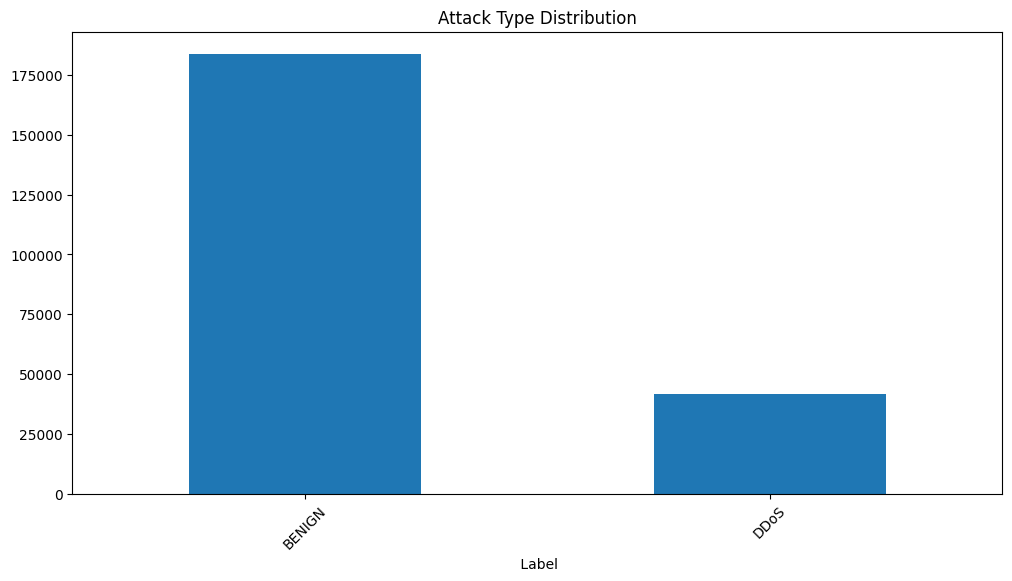

In [11]:
plt.figure(figsize=(12, 6))
df[' Label'].value_counts().plot(kind='bar')
plt.title('Attack Type Distribution')
plt.xticks(rotation=45)
plt.show()

In [10]:
#display coloumns
df.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [12]:
# Basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


         Source Port   Destination Port       Protocol   Flow Duration  \
count  225745.000000       225745.00000  225745.000000    2.257450e+05   
mean    38257.568402         8879.61946       7.600288    1.624165e+07   
std     23057.302075        19754.64740       3.881586    3.152437e+07   
min         0.000000            0.00000       0.000000   -1.000000e+00   
25%     18990.000000           80.00000       6.000000    7.118000e+04   
50%     49799.000000           80.00000       6.000000    1.452333e+06   
75%     58296.000000           80.00000       6.000000    8.805237e+06   
max     65534.000000        65532.00000      17.000000    1.199999e+08   

        Total Fwd Packets   Total Backward Packets  \
count       225745.000000            225745.000000   
mean             4.874916                 4.572775   
std             15.422874                21.755356   
min              1.000000                 0.000000   
25%              2.000000                 1.000000   
50%      

## Data Preprocessing

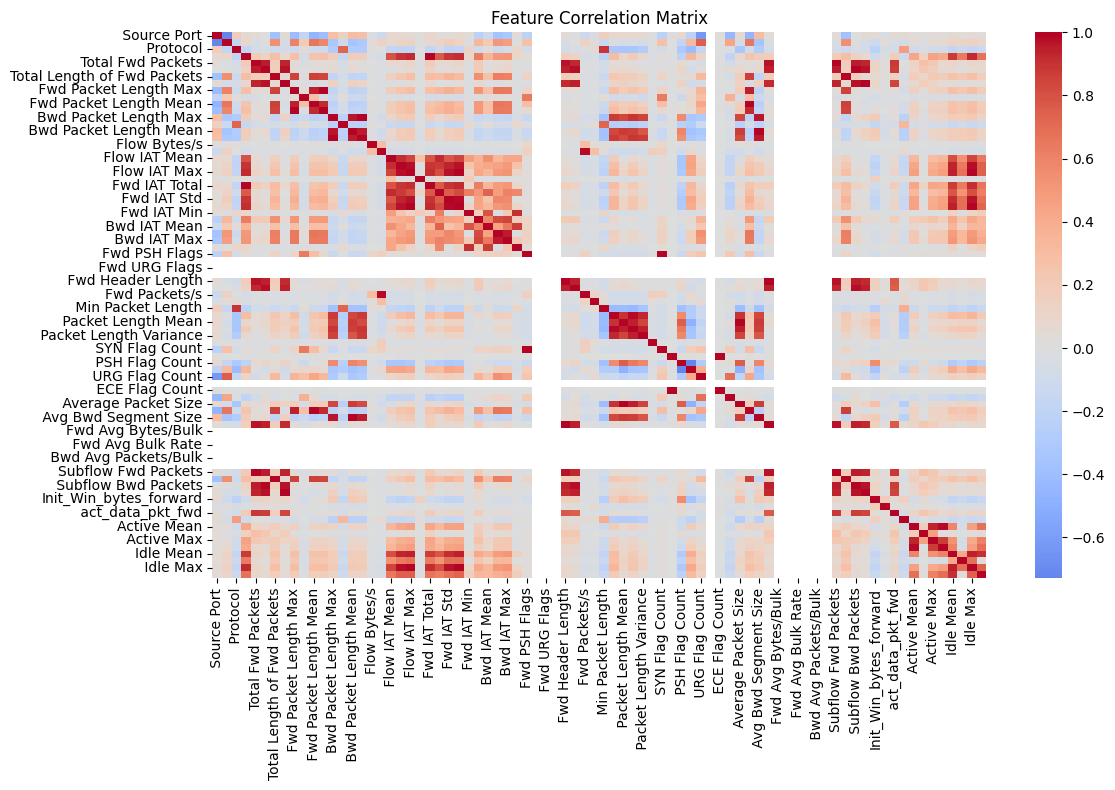

In [13]:
# 1. Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [21]:
#checking Nan values
df.isna().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
External IP          0
Length: 86, dtype: int64

In [20]:
# Removing NaN values
df = df.dropna()

### Feature Selection and Engineering

In [14]:
# Convert timestamp if present
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Hour'] = df['Timestamp'].dt.hour
    df['Minute'] = df['Timestamp'].dt.minute
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

In [15]:
flow_features = {}

if 'Flow Duration' in df.columns:
    # Packet rate features
    if 'Total Fwd Packets' in df.columns:
        df['Fwd_Packets_per_sec'] = df['Total Fwd Packets'] / (df['Flow Duration'] + 1e-10)
    if 'Total Backward Packets' in df.columns:
        df['Bwd_Packets_per_sec'] = df['Total Backward Packets'] / (df['Flow Duration'] + 1e-10)

# Protocol encoding
if 'Protocol' in df.columns:
    df = pd.get_dummies(df, columns=['Protocol'], prefix='Proto')

In [43]:
def analyze_features(df, target_col=' Label'):
    """Analyze and visualize feature importance"""
    from sklearn.ensemble import RandomForestClassifier
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)


    X = df.drop([' Label',  ' Source IP', ' Destination IP', ' Timestamp'], axis=1)
    # df.drop(['Label', 'Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'External IP'], axis=1)
    y = df[target_col]
    
    # Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Plot feature importance
    feature_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_imp.head(20), x='importance', y='feature')
    plt.title('Top 20 Important Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return feature_imp

In [44]:
feature_imp = analyze_features(df)

ValueError: Input X contains infinity or a value too large for dtype('float32').

In [40]:
feature_importance = analyze_features(df)


ValueError: could not convert string to float: '172.16.0.1'

/tmp/ipykernel_27054/68175824.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_27054/68175824.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_27054/68175824.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_27054/68175824.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_27054/68175824.py:7: UserWarning: set_ticklabels(

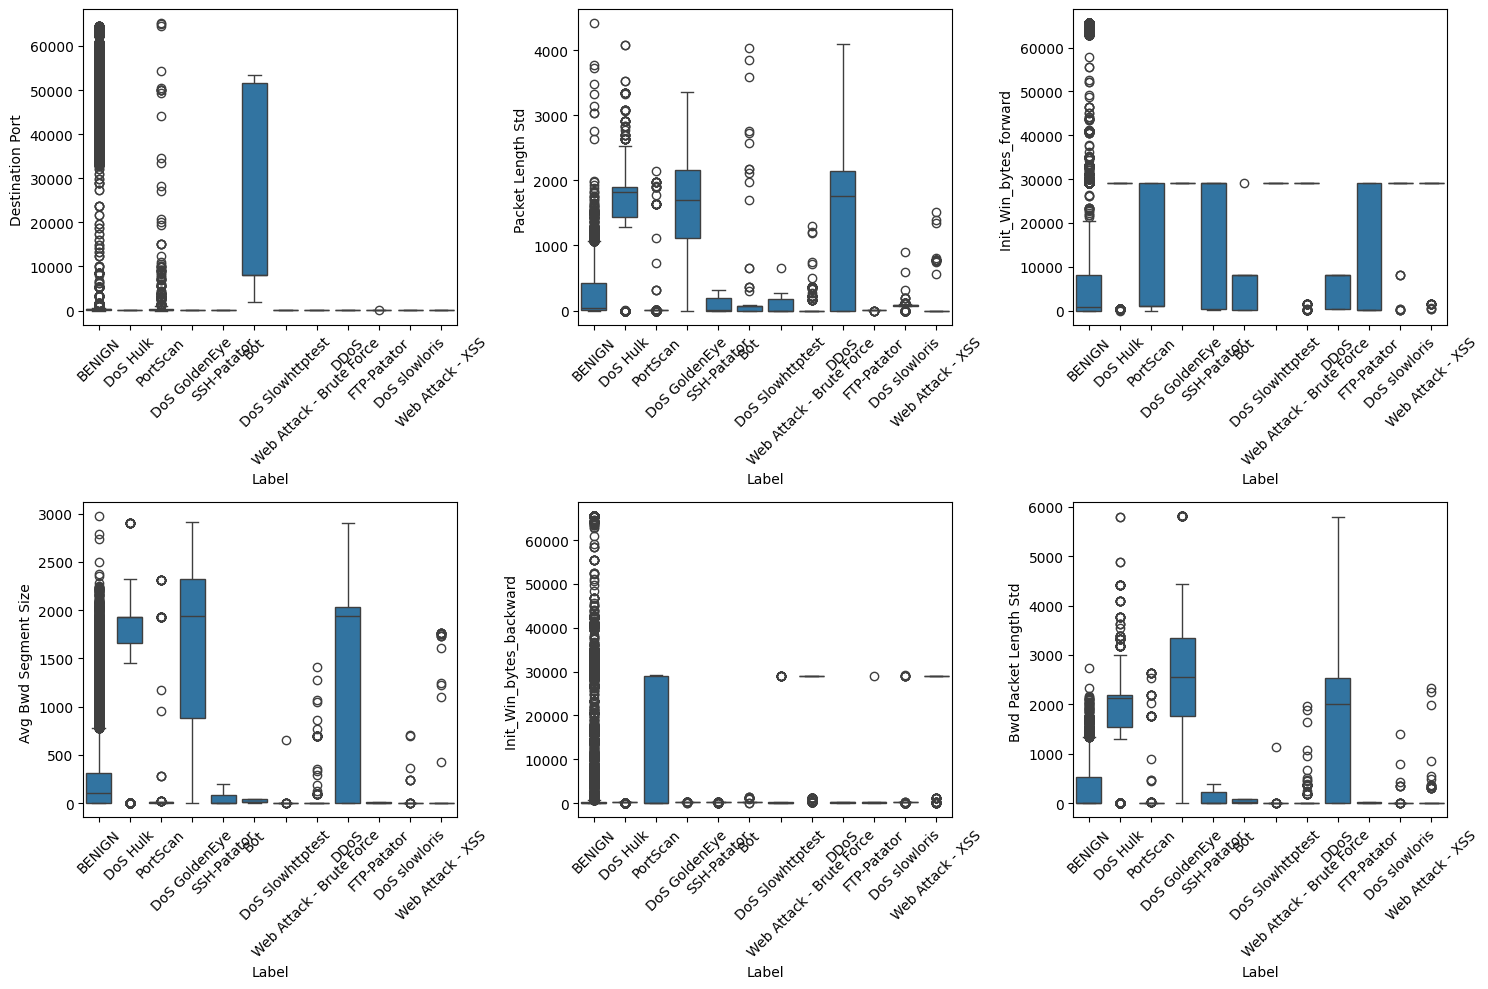

In [43]:
key_features = feature_importance['feature'].head(6).tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    sns.boxplot(data=df, y=feature, x='Label', ax=axes[idx])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    
plt.tight_layout()
plt.show()


In [23]:
if 'Total Fwd Packets' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df,
        x='Total Fwd Packets',
        y='Total Backward Packets',
        hue='Label',
        alpha=0.5
    )
    plt.title('Forward vs Backward Packets by Attack Type')
    plt.tight_layout()
    plt.show()

## Model Building - GNN

### Data Loading

In [26]:
class CICIDSDataLoader:
    def __init__(self, df, target_col=' Label', test_size=0.2, val_size= 0.1):
        self.df = df
        self.target_col = target_col
        self.test_size = test_size
        self.val_size = val_size
        self.scaler = StandardScaler()
        
    def prepare_data(self):
        """Prepare data for GNN training"""
        # Split features and target
        X = self.df.drop(self.target_col, axis=1)
        y = self.df[self.target_col]
        
        # Scale features
        X_scaled = pd.DataFrame(
            self.scaler.fit_transform(X),
            columns=X.columns
        )
        
        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_scaled, y, 
            test_size=self.test_size, 
            random_state=42,
            stratify=y
        )
        
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            random_state=42,
            stratify=y_temp
        )
        
        return X_train, X_val, X_test, y_train, y_val, y_test

In [27]:
data_loader = CICIDSDataLoader(df)
X_train, X_val, X_test, y_train, y_val, y_test = data_loader.prepare_data()

ValueError: could not convert string to float: '172.16.0.1-192.168.10.50-49650-80-6'

### Graph Creation

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data, HeteroData

class IDSGraphBuilder:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def preprocess_features(self, df):
        """Preprocess and normalize features."""
        # Convert protocol to numeric
        df['Protocol'] = pd.Categorical(df['Protocol']).codes
        
        # Handle timestamp
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['hour'] = df['Timestamp'].dt.hour
        df['minute'] = df['Timestamp'].dt.minute
        
        return df
        
    def build_heterogeneous_graph(self, df):
        """
        Strategy 1: Build heterogeneous graph with hosts and flows as nodes
        Returns: HeteroData object for heterogeneous GNN
        """
        # Create unique identifiers for hosts and flows
        unique_hosts = pd.concat([df['Source IP'], df['Destination IP']]).unique()
        host_mapping = {ip: idx for idx, ip in enumerate(unique_hosts)}
        
        # Host node features
        host_features = {
            ip: {
                'degree': len(df[(df['Source IP'] == ip) | (df['Destination IP'] == ip)]),
                'out_degree': len(df[df['Source IP'] == ip]),
                'in_degree': len(df[df['Destination IP'] == ip]),
                'unique_ports': len(pd.concat([
                    df[df['Source IP'] == ip]['Source Port'],
                    df[df['Destination IP'] == ip]['Destination Port']
                ]).unique())
            } for ip in unique_hosts
        }
        
        # Flow node features
        flow_features = [
            'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
            'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
            'Packet Length Mean', 'Packet Length Std',
            'PSH Flag Count', 'ACK Flag Count', 'Protocol',
            'hour', 'minute'
        ]
        
        # Create HeteroData object
        data = HeteroData()
        
        # Add host nodes
        host_feature_matrix = torch.tensor([
            [
                host_features[ip]['degree'],
                host_features[ip]['out_degree'],
                host_features[ip]['in_degree'],
                host_features[ip]['unique_ports']
            ] for ip in unique_hosts
        ], dtype=torch.float)
        data['host'].x = host_feature_matrix
        
        # Add flow nodes
        flow_feature_matrix = torch.tensor(
            self.scaler.fit_transform(df[flow_features].values),
            dtype=torch.float
        )
        data['flow'].x = flow_feature_matrix
        
        # Create edges
        source_edges = torch.tensor([
            [host_mapping[row['Source IP']], i]
            for i, row in df.iterrows()
        ], dtype=torch.long).t()
        dest_edges = torch.tensor([
            [i, host_mapping[row['Destination IP']]]
            for i, row in df.iterrows()
        ], dtype=torch.long).t()
        
        data['host', 'sends', 'flow'].edge_index = source_edges
        data['flow', 'received_by', 'host'].edge_index = dest_edges
        
        # Add labels for flows
        data['flow'].y = torch.tensor(
            pd.Categorical(df['Label']).codes,
            dtype=torch.long
        )
        
        return data
    
    def build_edge_focused_graph(self, df):
        """
        Strategy 2: Build graph with hosts as nodes and flows as edges
        Returns: NetworkX graph for edge-focused GNN
        """
        G = nx.DiGraph()
        
        # Node features (for hosts)
        node_features = {}
        for ip in pd.concat([df['Source IP'], df['Destination IP']]).unique():
            sent_flows = df[df['Source IP'] == ip]
            received_flows = df[df['Destination IP'] == ip]
            
            node_features[ip] = {
                'degree': len(sent_flows) + len(received_flows),
                'out_degree': len(sent_flows),
                'in_degree': len(received_flows),
                'unique_source_ports': len(sent_flows['Source Port'].unique()),
                'unique_dest_ports': len(received_flows['Destination Port'].unique()),
                'protocols_used': len(pd.concat([
                    sent_flows['Protocol'],
                    received_flows['Protocol']
                ]).unique())
            }
        
        # Add nodes with features
        for ip, features in node_features.items():
            G.add_node(ip, **features)
        
        # Edge features (for flows)
        edge_features = [
            'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
            'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
            'Flow Bytes/s', 'Flow Packets/s',
            'Fwd IAT Mean', 'Bwd IAT Mean',
            'Fwd PSH Flags', 'Bwd PSH Flags',
            'Packet Length Mean', 'Packet Length Std',
            'Protocol', 'hour', 'minute'
        ]
        
        # Add edges with features
        for _, row in df.iterrows():
            edge_data = {
                'port_pair': (row['Source Port'], row['Destination Port']),
                'features': self.scaler.fit_transform(
                    row[edge_features].values.reshape(1, -1)
                )[0],
                'label': row['Label']
            }
            G.add_edge(row['Source IP'], row['Destination IP'], **edge_data)
        
        return G

    def convert_to_pytorch_geometric(self, nx_graph):
        """Convert NetworkX graph to PyTorch Geometric Data object for edge-focused GNN."""
        # Create node mapping
        node_mapping = {node: idx for idx, node in enumerate(nx_graph.nodes())}
        
        # Prepare node features
        node_features = torch.tensor([
            [
                nx_graph.nodes[node]['degree'],
                nx_graph.nodes[node]['out_degree'],
                nx_graph.nodes[node]['in_degree'],
                nx_graph.nodes[node]['unique_source_ports'],
                nx_graph.nodes[node]['unique_dest_ports'],
                nx_graph.nodes[node]['protocols_used']
            ] for node in nx_graph.nodes()
        ], dtype=torch.float)
        
        # Prepare edge indices and features
        edge_index = []
        edge_features = []
        edge_labels = []
        
        for source, target, data in nx_graph.edges(data=True):
            edge_index.append([node_mapping[source], node_mapping[target]])
            edge_features.append(data['features'])
            edge_labels.append(1 if data['label'] != 'BENIGN' else 0)
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_features = torch.tensor(edge_features, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        
        # Create PyG Data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_features,
            edge_label=edge_labels
        )
        
        return data

## Training and Testing

## Evaluation